<a href="https://colab.research.google.com/github/codeplinth/pytorchbootcamp/blob/master/PyTorch_32_Dropout_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [4]:
torch.manual_seed(0)

In [7]:
# Create Data object
class Data(Dataset):
  def __init__(self, N_SAMPLES=40, noise_std=1, train=True):
    self.x = torch.linspace(-1, 1, N_SAMPLES).view(-1, 1)
    self.f = self.x ** 2
    if train != True:
        torch.manual_seed(1)
        self.y = self.f + noise_std * torch.randn(self.f.size())
        self.y = self.y.view(-1, 1)
        torch.manual_seed(0)
    else:
        self.y = self.f + noise_std * torch.randn(self.f.size())
        self.y = self.y.view(-1, 1)
    
  def __getitem__(self, idx):    
    return self.x[idx], self.y[idx]
  
  def __len__(self):
    return self.len
  
  def plot(self):
    plt.figure(figsize = (6.1, 10))
    plt.scatter(self.x.numpy(), self.y.numpy(), label="Samples")
    plt.plot(self.x.numpy(), self.f.numpy() ,label="True Function", color='orange')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((-1, 1))
    plt.ylim((-2, 2.5))
    plt.legend(loc="best")
    plt.show()

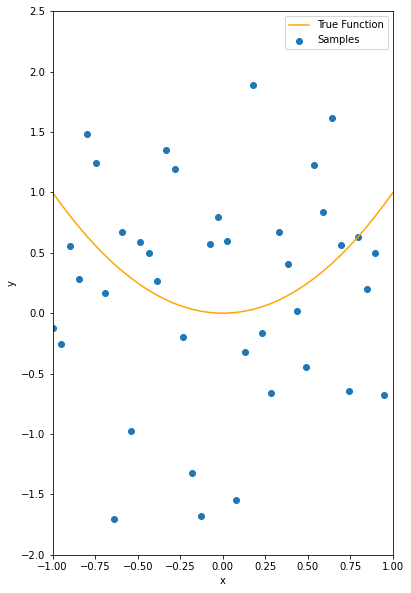

In [8]:
#create the dataset object and plot it
data_set = Data()
data_set.plot()

In [9]:
#create validation dataset
validation_dataset = Data(train=False)

In [15]:
#create the model class
class RegressionModel(nn.Module):
  def __init__(self,D_in,H,D_out,p=0):
    super(RegressionModel,self).__init__()
    self.l1 = nn.Linear(D_in,H)
    self.l2 = nn.Linear(H,H)
    self.l3 = nn.Linear(H,D_out)
    self.dropout = nn.Dropout(p=p)

  def forward(self,x):
    out1 = F.relu(self.dropout(self.l1(x)))
    out2 = F.relu(self.dropout(self.l2(out1)))
    y_pred = self.l3(out2)
    return y_pred


In [16]:
model = RegressionModel(1,300,1)
model_drop = RegressionModel(1,300,1,p=0.5) 

In [17]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.01)
optimizer_drop = optim.Adam(model_drop.parameters(),lr = 0.01)

In [18]:
LOSS = {'Training loss no dropout':[],
        'Validation loss no dropout':[],
        'Training loss dropout':[],
        'Validation loss dropout':[]}

In [19]:
EPOCHS = 500
def train_model(EPOCHS):
  for epoch in range(EPOCHS):
    y_pred = model(data_set.x)
    y_pred_drop = model_drop(data_set.x)
    loss = criterion(y_pred,data_set.y)
    loss_drop = criterion(y_pred_drop,data_set.y)

    LOSS['Training loss no dropout'].append(loss.item())
    LOSS['Validation loss no dropout'].append(criterion(model(validation_dataset.x),validation_dataset.y).item())
    LOSS['Training loss dropout'].append(loss_drop.item())
    model_drop.eval()
    LOSS['Validation loss dropout'].append(criterion(model_drop(validation_dataset.x),validation_dataset.y).item())
    model_drop.train()

    optimizer.zero_grad()
    optimizer_drop.zero_grad()
    loss.backward()
    loss_drop.backward()
    optimizer.step()
    optimizer_drop.step()

train_model(EPOCHS)

In [20]:
model_drop.eval()

RegressionModel(
  (l1): Linear(in_features=1, out_features=300, bias=True)
  (l2): Linear(in_features=300, out_features=300, bias=True)
  (l3): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [21]:
y_pred = model(data_set.x)
y_pred_drop = model_drop(data_set.x)

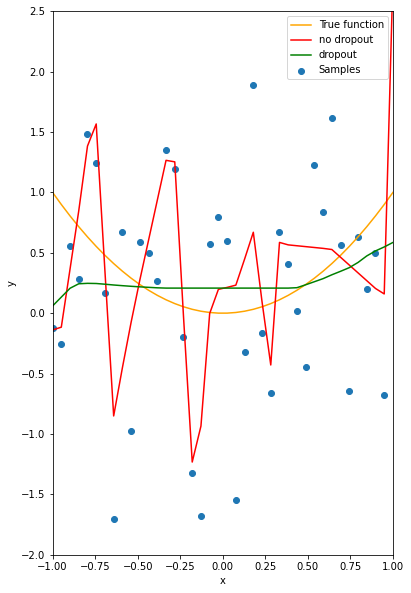

In [24]:
plt.figure(figsize=(6.1, 10))

plt.scatter(data_set.x.numpy(), data_set.y.numpy(), label="Samples")
plt.plot(data_set.x.numpy(), data_set.f.numpy(), label="True function", color='orange')
plt.plot(data_set.x.numpy(), y_pred.detach().numpy(), label='no dropout', c='r')
plt.plot(data_set.x.numpy(), y_pred_drop.detach().numpy(), label="dropout", c ='g')

plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend(loc = "best")
plt.show()

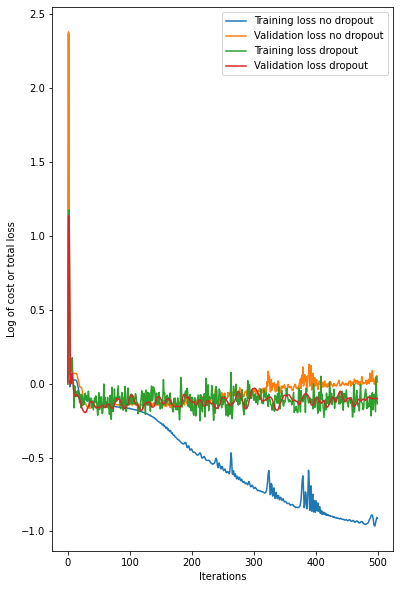

In [28]:
# Plot the loss
plt.figure(figsize=(6.1, 10))
for k,v in LOSS.items():
    plt.plot(np.log(np.array(v)), label=k)
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Log of cost or total loss")